In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-jan-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jan-2022/train.csv
/kaggle/input/tabular-playground-series-jan-2022/test.csv


In [2]:
import warnings
import gc
import tensorflow as tf

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor


warnings.filterwarnings("ignore")

In [3]:
def smape(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    num = tf.math.abs(tf.math.subtract(y_true, y_pred))
    denom = tf.math.add(tf.math.abs(y_true), tf.math.abs(y_pred))
    denom = tf.math.divide(denom,200.0)
    
    val = tf.math.divide(num,denom)
    val = tf.where(denom == 0.0, 0.0, val) 
    return tf.reduce_mean(val)

In [4]:
def evaluate_model(model, x, y):
    y_pred = model.predict(x)
    result = smape(y, y_pred)
    return result

In [5]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
def preprocess(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.day_of_week
    df['weekday'] = df['date'].dt.weekday
    df['week'] = df['date'].dt.week
    df['quarter'] = df['date'].dt.quarter
    df['day_of_year'] = df['date'].dt.day_of_year
    df['weekofyear'] = df['date'].dt.weekofyear
    return df

In [6]:
seed = 47

# XGBOOST -  ONGOING WORK

# Reading the dataset and preprocessing the dataset

In [7]:
train_df = pd.read_csv("/kaggle/input/tabular-playground-series-jan-2022/train.csv", sep=',')

country = {c : i for i, c in enumerate(train_df['country'].unique())}
store = {s : i for i, s in enumerate(train_df['store'].unique())}
product = {p : i for i, p in enumerate(train_df['product'].unique())}

train_df['country'] = train_df['country'].replace(country)
train_df['store'] = train_df['store'].replace(store)
train_df['product'] = train_df['product'].replace(product)

train_df = preprocess(train_df)
x_train = train_df.drop(['row_id', 'date', 'num_sold'], axis=1)
y_train = train_df['num_sold']
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=seed, shuffle=False)

In [8]:
params = {'n_estimators': 200, 
          'max_depth': 23, 
          'subsample': 1.0,
          'eta': 0.3,
          'colsample_bytree': 1.0,
          'gamma': 0.0, 
          'min_child_weight': 1,
          'reg_alpha': 1
         }

model =  XGBRegressor(**params,
                      objective='reg:linear',
                      random_state=seed,
                      early_stopping_rounds=200,
                      verbosity=0)
model.fit(x_train, y_train, verbose=True)
score = evaluate_model(model, x_test, y_test)
print(score)

tf.Tensor(9.654826, shape=(), dtype=float32)



User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

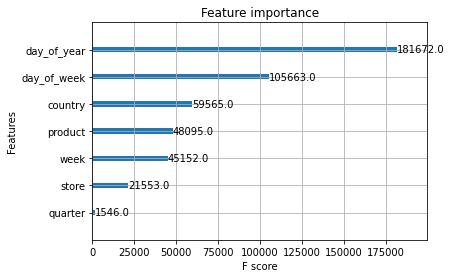

In [9]:
from xgboost import plot_importance

plot_importance(model)

# Submission

In [10]:
del train_df, x_train, y_train, x_test, y_test
gc.collect()

26

In [11]:
test_df = pd.read_csv("/kaggle/input/tabular-playground-series-jan-2022/test.csv", sep=',')
test_df['country'] = test_df['country'].replace(country)
test_df['store'] = test_df['store'].replace(store)
test_df['product'] = test_df['product'].replace(product)
test_df = preprocess(test_df)
x_test = test_df.drop(['row_id', 'date'], axis=1)

In [12]:
target = model.predict(x_test).squeeze()
row_id =  test_df['row_id'].values
submission = pd.DataFrame({'row_id' : row_id, 'num_sold' : target})

In [13]:
submission.head()

,row_id,num_sold
0,26298,405.840576
1,26299,618.817078
2,26300,175.985733
3,26301,666.977905
4,26302,1039.609863


In [14]:
submission.to_csv('submission.csv', index=False)